In [1]:
from openai import OpenAI
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
plt.style.use('seaborn-v0_8')

In [12]:
with open('openai_api_key.py') as script:
    exec(script.readline())

client = OpenAI(
  api_key=openai_api_key,
)

In [13]:
def run_experiment(model, prompt, instruction, temperature, n, max_tokens=1):
    answers = []
    for _ in range(n):
        response = client.chat.completions.create(
            model=model,  
            messages=[
                {"role": "system", "content": instruction},

                {"role": "user", "content": prompt}
            ],
            max_tokens=max_tokens,
            temperature=temperature
        )

        # Store the answer in the list
        answer = response.choices[0].message.content
        answers.append(answer.strip())
        
        # Add delay before the next API call
        if model == 'gpt-4-1106-preview':
            # 500 requests per minute
            time.sleep(60/500)
        elif model == 'gpt-3.5-turbo-1106':
            # 3500 requests per minute
            time.sleep(60/3500)
        
        progress_bar.update(1)

    return answers

## Experiment 1

Prompt:

*Assume that you have spent `$90/$250` for a ticket to a theater performance. Several weeks later you buy a `$30` ticket to a rock concert. You think you will enjoy the rock concert more than the theater performance. As you are putting your just-purchased rock concert ticket in your wallet, you notice that both events are scheduled for the same evening. The tickets are non-transferable, nor can they be exchanged. You can use only one of the tickets and not the other. Which ticket will you use?*

*A: Theater performance.*

*B: Rock concert.*

---

From:

- Soman, D. 2001. The mental accounting of sunk time costs: why time is not like money. Journal of Behavioral Decision Making 14(3): 169–185.

- Arkes, H.R., and C. Blumer. 1985. The psychology of sunk cost. Organizational Behavior and Human
Decision Processes 35(1): 124–140.

(both Experiment 1)

---

In [43]:
def sunk_cost_experiment(model, prompt, instruction, temperature, n, max_tokens=1):
    answers = run_experiment(model, prompt, instruction, temperature, n, max_tokens)
    
    theater_share = answers.count('A') / len(answers)
    rock_share = answers.count('B') / len(answers)
    
    results = [model, temperature, sunk_cost, theater_share, rock_share]
    
    return results, answers

In [44]:
models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106']
temperatures = [0.5, 1, 1.5]
sunk_costs = [90, 250, 10_000]

instruction = 'Please answer by only giving the letter of the answer option A or B.'

In [45]:
results_list = []
answers_storage = []  # Not necessary, for control purposes only

n = 50

progress_bar = tqdm(range(len(models) * len(temperatures) * len(sunk_costs) * n))

for model in models:
    for temperature in temperatures:
        for sunk_cost in sunk_costs:
            prompt = f"""Assume that you have spent ${sunk_cost} for a ticket to a theater performance. \
Several weeks later you buy a $30 ticket to a rock concert. You think you \
will enjoy the rock concert more than the theater performance. As you are \
putting your just-purchased rock concert ticket in your wallet, you notice \
that both events are scheduled for the same evening. The tickets are \
non-transferable, nor can they be exchanged. You can use only one of the \
tickets and not the other. Which ticket will you use?

A: Theater performance.
B: Rock concert."""
            
            results, answers = sunk_cost_experiment(model, prompt, instruction, temperature, n)
            answers_storage.append(answers)  # Not necessary, for control purposes only
            results_list.append(results)

100%|██████████| 900/900 [07:52<00:00,  2.06it/s]

In [46]:
columns = ['Model', 'Temperature', 'Sunk Cost ($)', 'Share Theater Performance', 'Share Rock Concert']

df = pd.DataFrame(results_list, columns=columns)
df

,Model,Temperature,Sunk Cost ($),Share Theater Performance,Share Rock Concert
0,gpt-4-1106-preview,0.5,90,0.00,1.00
1,gpt-4-1106-preview,0.5,250,0.00,1.00
2,gpt-4-1106-preview,0.5,10000,0.00,1.00
3,gpt-4-1106-preview,1.0,90,0.00,1.00
4,gpt-4-1106-preview,1.0,250,0.00,1.00
5,gpt-4-1106-preview,1.0,10000,0.04,0.96
6,gpt-4-1106-preview,1.5,90,0.02,0.98
7,gpt-4-1106-preview,1.5,250,0.00,1.00
8,gpt-4-1106-preview,1.5,10000,0.10,0.90
9,gpt-3.5-turbo-1106,0.5,90,0.00,1.00


In [47]:
df.to_csv('Output/Sunk_cost_experiment_1.csv')

Conclusion: GPT-4 and GPT-3 is not significantly affected by sunk cost bias, a slight impact is still observed, especially if the temperature and sunk costs are increased.

---
## Experiment 2
From
- Thaler, Richard (2015), "Misbehaving"

In [14]:
prompt1 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: $0. I alreadey paid for it.
B: $20, what I paid for.
C: $20, plus interest.
D: $75, what I could get if I sold the bottle.
E: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle."""

prompt2 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: $75, what I could get if I sold the bottle.
B: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle.
C: $0. I alreadey paid for it.
D: $20, what I paid for.
E: $20, plus interest."""

prompt3 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle.
B: $75, what I could get if I sold the bottle.
C: $20, plus interest.
D: $0. I alreadey paid for it.
E: $20, what I paid for."""

In [15]:
prompts = [prompt1, prompt2, prompt3]

models = ['gpt-4-1106-preview', 'gpt-3.5-turbo-1106']

temperatures = [0.5, 1, 1.5]

instruction = 'Please answer by only giving the letter of the answer option A, B, C, D or E.'

In [17]:
results_list = []
answers_storage = []  # Not necessary, for control purposes only

n = 50

progress_bar = tqdm(range(len(models) * len(temperatures) * len(prompts) * n))

prompt_answers_mapping = {
    0: ['A', 'B', 'C', 'D', 'E'],
    1: ['C', 'D', 'E', 'A', 'B'],
    2: ['D', 'E', 'C', 'B', 'A']
}


for model in models:
    for i, prompt in enumerate(prompts):
        for temperature in temperatures:
            results = [model, i, temperature]
            
            answers = run_experiment(model, prompt, instruction, temperature, n)

            for option in prompt_answers_mapping[i]:
                share = answers.count(option) / len(answers)
                results.append(share)
            
            answers_storage.append(answers)  # Not necessary, for control purposes only
            results_list.append(results) 

100%|██████████| 900/900 [38:19<00:00,  1.78it/s]    

In [18]:
columns = ['Model', 'Prompt', 'Temperature', '$0', '$20', '$20 plus interest', '$75', '-$55']

df = pd.DataFrame(results_list, columns=columns)
df

,Model,Prompt,Temperature,$0,$20,$20 plus interest,$75,-$55
0,gpt-4-1106-preview,0,0.5,0.00,0.00,0.00,1.00,0.00
1,gpt-4-1106-preview,0,1.0,0.00,0.00,0.00,1.00,0.00
2,gpt-4-1106-preview,0,1.5,0.00,0.00,0.00,1.00,0.00
3,gpt-4-1106-preview,1,0.5,0.00,0.00,0.00,1.00,0.00
4,gpt-4-1106-preview,1,1.0,0.00,0.00,0.00,1.00,0.00
5,gpt-4-1106-preview,1,1.5,0.00,0.00,0.00,1.00,0.00
6,gpt-4-1106-preview,2,0.5,0.00,0.00,0.00,1.00,0.00
7,gpt-4-1106-preview,2,1.0,0.00,0.00,0.00,1.00,0.00
8,gpt-4-1106-preview,2,1.5,0.00,0.00,0.02,0.98,0.00
9,gpt-3.5-turbo-1106,0,0.5,0.00,0.08,0.00,0.00,0.92


In [19]:
# Add results from the real experiment
real_experiment_results = {
    'Model': ['Real Experiment'],
    'Prompt': [np.nan],
    '$0': [0.30],
    '$20': [0.18],
    '$20 plus interest': [0.07],
    '$75': [0.20],
    '-$55': [0.25]
}

real_df = pd.DataFrame(real_experiment_results)
df = pd.concat([df, real_df], ignore_index=True)

In [20]:
df

,Model,Prompt,Temperature,$0,$20,$20 plus interest,$75,-$55
0,gpt-4-1106-preview,0.0,0.5,0.00,0.00,0.00,1.00,0.00
1,gpt-4-1106-preview,0.0,1.0,0.00,0.00,0.00,1.00,0.00
2,gpt-4-1106-preview,0.0,1.5,0.00,0.00,0.00,1.00,0.00
3,gpt-4-1106-preview,1.0,0.5,0.00,0.00,0.00,1.00,0.00
4,gpt-4-1106-preview,1.0,1.0,0.00,0.00,0.00,1.00,0.00
5,gpt-4-1106-preview,1.0,1.5,0.00,0.00,0.00,1.00,0.00
6,gpt-4-1106-preview,2.0,0.5,0.00,0.00,0.00,1.00,0.00
7,gpt-4-1106-preview,2.0,1.0,0.00,0.00,0.00,1.00,0.00
8,gpt-4-1106-preview,2.0,1.5,0.00,0.00,0.02,0.98,0.00
9,gpt-3.5-turbo-1106,0.0,0.5,0.00,0.08,0.00,0.00,0.92


In [ ]:
df.to_csv('Output/Sunk_cost_experiment_2.csv')

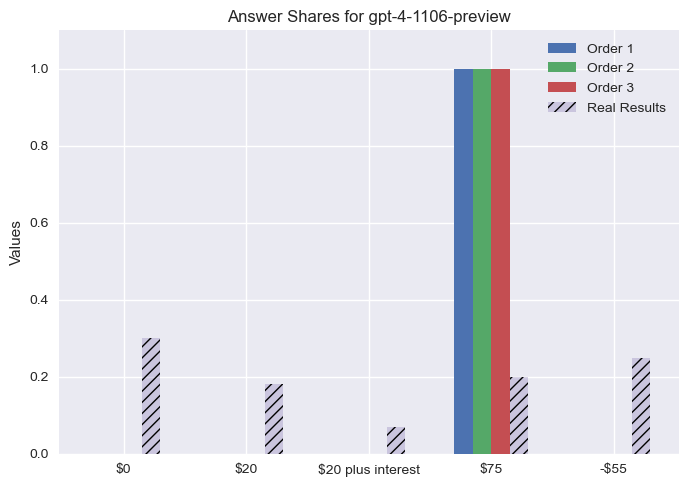

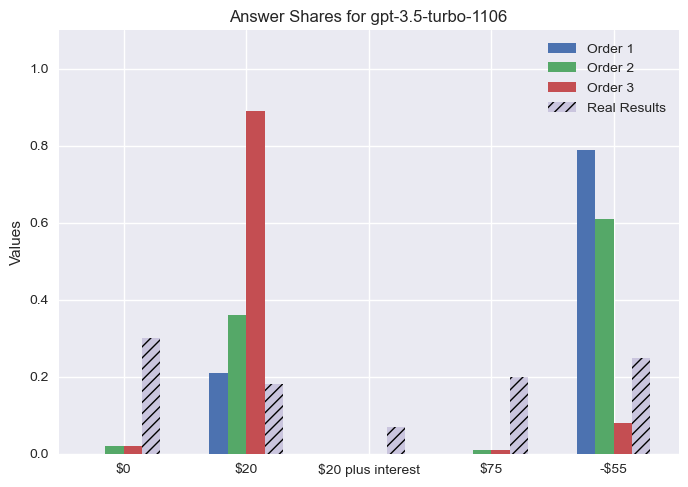

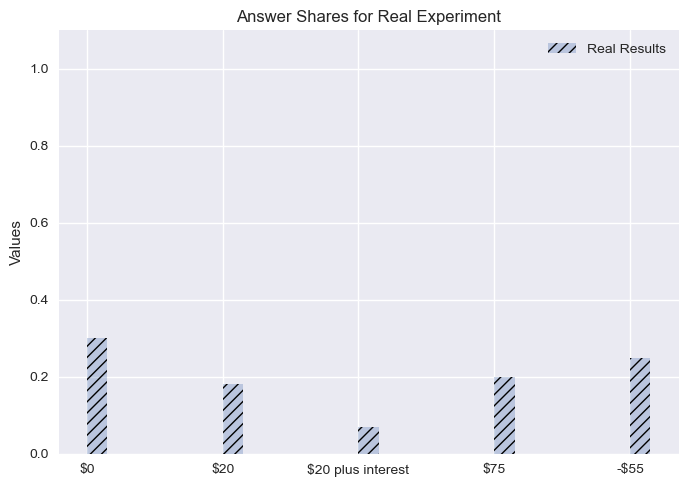

In [29]:
# Get unique models
models = df['Model'].unique()

# Set the width of the bars
bar_width = 0.15

# Define bar positions for different categories
bar_positions = np.arange(len(df.columns[2:]))

# Iterate over each model to create individual bar plots
for model in models:
    plt.figure()

    # Get unique prompts for the current model
    prompts = df[df['Model'] == model]['Prompt'].unique()

    # Iterate over prompts to plot bars for each category
    for i, prompt in enumerate(prompts):
        subset = df[(df['Model'] == model) & (df['Prompt'] == prompt)]

        # Check if the subset is not empty before accessing values
        if not subset.empty:
            plt.bar(
                bar_positions + (i * bar_width),
                subset.iloc[0, 2:].values,
                width=bar_width,
                label=f'Order {i + 1}'
            )

    # Add bars for real experiment results with reduced opacity
    real_experiment_subset = df[df['Model'] == 'Real Experiment']

    # Check if the subset is not empty before accessing values
    if not real_experiment_subset.empty:
        plt.bar(
            bar_positions + (len(prompts) * bar_width),
            real_experiment_subset.iloc[0, 2:].values,
            width=bar_width,
            label='Real Results',
            alpha=0.3,
            hatch='///'
        )

    # Customize plot details
    plt.title(f'Answer Shares for {model}')
    plt.ylabel('Values')
    plt.xticks(bar_positions + ((len(prompts)) / 2 * bar_width), ['$0', '$20', '$20 plus interest', '$75', '-$55'],
               fontsize=10)
    plt.ylim(0, 1.1)
    plt.legend()
    plt.grid(True)

# Show all plots
plt.show()

Conclusion: GPT-4 Turbo consistently selects answer "`$75`", which is the correct answer according to economic theory, but not what humans would choose. GPT-3 Turbo mostly chooses either "`$20`" or "`-$55`", but the distribution depends on the order of the answer options.

---

## Llama 2

Llama 2 has 3 different sizes:

- llama-2-70b-chat ("meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3")

- llama-2-13b-chat ("meta/llama-2-13b-chat:f4e2de70d66816a838a89eeeb621910adffb0dd0baba3976c96980970978018d")

- llama-2-7b-chat ("meta/llama-2-7b-chat:13c3cdee13ee059ab779f0291d29054dab00a47dad8261375654de5540165fb0")

"Larger models are more accurate and intelligent but they are more expensive and have higher latency, whereas the smaller model are faster and cheaper to run, but less accurate than the larger models."

In [2]:
import replicate
import os

In [3]:
REPLICATE_API_TOKEN = os.environ["REPLICATE_API_TOKEN"]

In [4]:
def run_experiment_with_llama(model, prompt, instruction, temperature, n, max_tokens=2):
    answers = []
    for _ in range(n):
        response = replicate.run(model,
                                 input = {
                                    "temperature": temperature,
                                    "system_prompt": instruction,
                                    "prompt": prompt,
                                    "max_new_tokens": max_tokens}
                                )

        # Store the answer in the list
        answer = ''
        for item in response:
            answer += item

        answers.append(answer.strip())
        
        # Add delay before the next API call
        # 50 requests per second
        time.sleep(1/50)
        
        progress_bar.update(1)

    return answers

## Experiment 1

In [5]:
models = ['meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3']

temperatures = [0.5, 1, 1.5]

sunk_costs = [90, 250, 10_000]

instruction = 'Please answer by only giving the letter of the answer option A or B.'

In [13]:
results_list = []
answers_storage = []  # Not necessary, for control purposes only

n = 50

progress_bar = tqdm(range(len(models) * len(temperatures) * len(sunk_costs) * n))

for model in models:
    for temperature in temperatures:
        for sunk_cost in sunk_costs:
            prompt = f"""Assume that you have spent ${sunk_cost} for a ticket to a theater performance. \
Several weeks later you buy a $30 ticket to a rock concert. You think you \
will enjoy the rock concert more than the theater performance. As you are \
putting your just-purchased rock concert ticket in your wallet, you notice \
that both events are scheduled for the same evening. The tickets are \
non-transferable, nor can they be exchanged. You can use only one of the \
tickets and not the other. Which ticket will you use?

A: Theater performance.
B: Rock concert."""
            
            answers = run_experiment_with_llama(model, prompt, instruction, temperature, n)
            
            valid_answers = answers.count('A') + answers.count('B')
    
            theater_share = answers.count('A') / valid_answers
            rock_share = answers.count('B') / valid_answers
            
            results = [model, temperature, sunk_cost, valid_answers, theater_share, rock_share]
            
            answers_storage.append(answers)  # Not necessary, for control purposes only
            results_list.append(results)

100%|██████████| 450/450 [15:01<00:00,  1.10s/it]  

In [14]:
columns = ['Model', 'Temperature', 'Sunk Cost ($)', 'Observations', 'Share Theater Performance', 'Share Rock Concert']

df = pd.DataFrame(results_list, columns=columns)

# Replace values in the "Model" column
df['Model'] = df['Model'].replace('meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3', 
                                  'llama-2-70b')

# Round numbers in the following columns
cols_to_round = ['Share Theater Performance', 'Share Rock Concert']

# Apply the round function to these columns
for col in cols_to_round:
    df[col] = df[col].round(2)

df

,Model,Temperature,Sunk Cost ($),Observations,Share Theater Performance,Share Rock Concert
0,llama-2-70b,0.5,90,50,0.0,1.0
1,llama-2-70b,0.5,250,50,0.0,1.0
2,llama-2-70b,0.5,10000,50,0.0,1.0
3,llama-2-70b,1.0,90,50,0.0,1.0
4,llama-2-70b,1.0,250,50,0.0,1.0
5,llama-2-70b,1.0,10000,50,0.0,1.0
6,llama-2-70b,1.5,90,50,0.0,1.0
7,llama-2-70b,1.5,250,50,0.0,1.0
8,llama-2-70b,1.5,10000,50,0.0,1.0


In [18]:
df_gpt = pd.read_csv('Output/Sunk_cost_experiment_1.csv', index_col=0)

df_combined = pd.concat([df_gpt, df], ignore_index=True)
df_combined

,Model,Temperature,Sunk Cost ($),Share Theater Performance,Share Rock Concert,Observations
0,gpt-4-1106-preview,0.5,90,0.00,1.00,NaN
1,gpt-4-1106-preview,0.5,250,0.00,1.00,NaN
2,gpt-4-1106-preview,0.5,10000,0.00,1.00,NaN
3,gpt-4-1106-preview,1.0,90,0.00,1.00,NaN
4,gpt-4-1106-preview,1.0,250,0.00,1.00,NaN
5,gpt-4-1106-preview,1.0,10000,0.04,0.96,NaN
6,gpt-4-1106-preview,1.5,90,0.02,0.98,NaN
7,gpt-4-1106-preview,1.5,250,0.00,1.00,NaN
8,gpt-4-1106-preview,1.5,10000,0.10,0.90,NaN
9,gpt-3.5-turbo-1106,0.5,90,0.00,1.00,NaN


In [19]:
df_combined.to_csv('Output/Sunk_cost_experiment_1_with_llama.csv')

## Experiment 2

In [5]:
prompt1 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: $0. I alreadey paid for it.
B: $20, what I paid for.
C: $20, plus interest.
D: $75, what I could get if I sold the bottle.
E: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle."""

prompt2 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: $75, what I could get if I sold the bottle.
B: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle.
C: $0. I alreadey paid for it.
D: $20, what I paid for.
E: $20, plus interest."""

prompt3 = """Suppose you bought a case of good Bordeaux in the futures \
market for $20 a bottle. The wine now sells at auction for about $75. \
You have decided to drink a bottle. Which of the following best captures \
your feeling of the cost to you of drinking the bottle?

A: -$55, I get to drink a bottle that is worth $75 that I only paid \
$20 for so I save money by drinking the bottle.
B: $75, what I could get if I sold the bottle.
C: $20, plus interest.
D: $0. I alreadey paid for it.
E: $20, what I paid for."""

In [6]:
prompts = [prompt1, prompt2, prompt3]

models = ['meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3']

temperatures = [0.5, 1, 1.5]

instruction = 'Please complete the answer by only giving the letter of the answer option A, B, C, D or E.'

In [7]:
results_list = []
answers_storage = []  # Not necessary, for control purposes only

n = 50

progress_bar = tqdm(range(len(models) * len(temperatures) * len(prompts) * n))

prompt_answers_mapping = {
    0: ['A', 'B', 'C', 'D', 'E'],
    1: ['C', 'D', 'E', 'A', 'B'],
    2: ['D', 'E', 'C', 'B', 'A']
}


for model in models:
    for i, prompt in enumerate(prompts):
        for temperature in temperatures:
            
            answers = run_experiment_with_llama(model, prompt, instruction, temperature, n)
            
            valid_answers = (answers.count('A')
                             + answers.count('B')
                             + answers.count('C')
                             + answers.count('D')
                             + answers.count('E'))
    
            results = [model, i, temperature, valid_answers]

            for option in prompt_answers_mapping[i]:
                share = answers.count(option) / valid_answers
                results.append(share)
            
            answers_storage.append(answers)  # Not necessary, for control purposes only
            results_list.append(results) 

100%|██████████| 450/450 [13:15<00:00,  1.11s/it]

In [35]:
columns = ['Model', 'Prompt', 'Temperature', 'Oberservations', '$0', '$20', '$20 plus interest', '$75', '-$55']

df = pd.DataFrame(results_list, columns=columns)

# Replace values in the "Model" column
df['Model'] = df['Model'].replace('meta/llama-2-70b-chat:02e509c789964a7ea8736978a43525956ef40397be9033abf9fd2badfe68c9e3', 
                                  'llama-2-70b')

# Round numbers in the following columns
cols_to_round = ['$0', '$20', '$20 plus interest', '$75', '-$55']

# Apply the round function to these columns
for col in cols_to_round:
    df[col] = df[col].round(2)

df

,Model,Prompt,Temperature,Oberservations,$0,$20,$20 plus interest,$75,-$55
0,llama-2-70b,0,0.5,50,1.00,0.0,0.0,0.00,0.00
1,llama-2-70b,0,1.0,50,0.76,0.0,0.0,0.00,0.24
2,llama-2-70b,0,1.5,44,0.50,0.0,0.0,0.07,0.43
3,llama-2-70b,1,0.5,50,0.00,0.0,0.0,0.00,1.00
4,llama-2-70b,1,1.0,50,0.00,0.0,0.0,0.00,1.00
5,llama-2-70b,1,1.5,41,0.00,0.0,0.0,0.00,1.00
6,llama-2-70b,2,0.5,50,0.00,0.0,0.0,0.00,1.00
7,llama-2-70b,2,1.0,50,0.00,0.0,0.0,0.00,1.00
8,llama-2-70b,2,1.5,43,0.09,0.0,0.0,0.00,0.91


In [10]:
df_gpt = pd.read_csv('Output/Sunk_cost_experiment_2.csv', index_col=0)

In [36]:
df_combined = pd.concat([df, df_gpt], ignore_index=True)
df_combined


,Model,Prompt,Temperature,Oberservations,$0,$20,$20 plus interest,$75,-$55
0,llama-2-70b,0.0,0.5,50.0,1.00,0.00,0.00,0.00,0.00
1,llama-2-70b,0.0,1.0,50.0,0.76,0.00,0.00,0.00,0.24
2,llama-2-70b,0.0,1.5,44.0,0.50,0.00,0.00,0.07,0.43
3,llama-2-70b,1.0,0.5,50.0,0.00,0.00,0.00,0.00,1.00
4,llama-2-70b,1.0,1.0,50.0,0.00,0.00,0.00,0.00,1.00
5,llama-2-70b,1.0,1.5,41.0,0.00,0.00,0.00,0.00,1.00
6,llama-2-70b,2.0,0.5,50.0,0.00,0.00,0.00,0.00,1.00
7,llama-2-70b,2.0,1.0,50.0,0.00,0.00,0.00,0.00,1.00
8,llama-2-70b,2.0,1.5,43.0,0.09,0.00,0.00,0.00,0.91
9,gpt-4-1106-preview,0.0,0.5,NaN,0.00,0.00,0.00,1.00,0.00


In [37]:
df_combined.to_csv('Output/Sunk_cost_experiment_2_with_llama.csv')